# Processing Sequences using RNNs and CNNs

Understanding the fundamentals of RNNs and using them to forecast a time series.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## Basic RNNs

Generating the dataset:

In [28]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

Forcasting 1 step ahead:

In [35]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1) # one step ahead
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

Saving figure time_series_plot


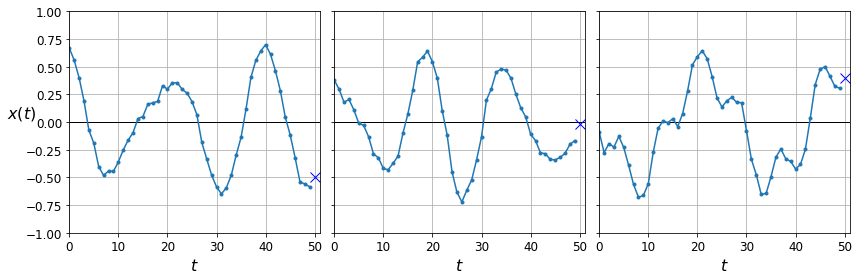

In [86]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()


### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [73]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020696178

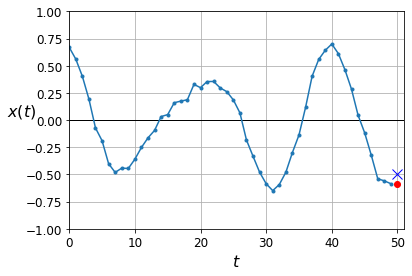

In [74]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another approach is to use a fully connected network.

Linear predictions:

In [75]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1000 - val_loss: 0.0529
Epoch 2/20
219/219 [==============================] - 0s 753us/step - loss: 0.0384 - val_loss: 0.0267
Epoch 3/20
219/219 [==============================] - 0s 670us/step - loss: 0.0207 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 0s 648us/step - loss: 0.0135 - val_loss: 0.0117
Epoch 5/20
219/219 [==============================] - 0s 724us/step - loss: 0.0105 - val_loss: 0.0096
Epoch 6/20
219/219 [==============================] - 0s 688us/step - loss: 0.0090 - val_loss: 0.0085
Epoch 7/20
219/219 [==============================] - 0s 660us/step - loss: 0.0081 - val_loss: 0.0077
Epoch 8/20
219/219 [==============================] - 0s 755us/step - loss: 0.0073 - val_loss: 0.0070
Epoch 9/20
219/219 [==============================] - 0s 691us/step - loss: 0.0067 - val_loss: 0.0065
Epoch 10/20
219/219 [==============================] - 0s 691us/step - loss: 0.0061 

In [77]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 617us/step - loss: 0.0042


0.00418860511854291

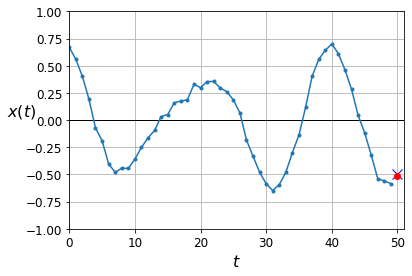

In [78]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a simple RNN

In [85]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) # input sequence length is not specified (None) as RNN can process any number of time steps
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0975 - val_loss: 0.0472
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0369 - val_loss: 0.0289
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0250 - val_loss: 0.0215
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0194 - val_loss: 0.0175
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0111 - val_loss: 0.0113

In [81]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0112


0.01121793407946825

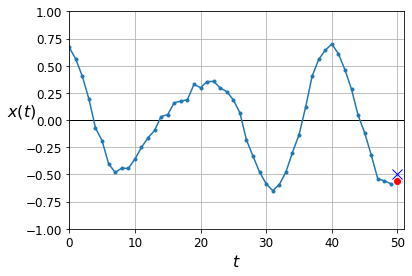

In [82]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [88]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=20,  validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0236 - val_loss: 0.0049
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 10/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0033 - val_lo

In [89]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 4ms/step - loss: 0.0026


0.0026208984199911356

The last layer in above model is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we have a single output value per time step.

SimpleRNN uses tanh activation function by default.

For above reasons, it is preferable to replace the output layer with a Dense layer:

In [90]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

history = model.fit(X_train, y_train, epochs=20,  validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0122 - val_loss: 0.0040
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0031 - val_lo

Now, it converges faster and performs just as well. 

### Forecasting Several Time Steps Ahead

One way is to use the model we already trained, make it predict the next value, then add that value to the inputs, and use the model again to predict the following value, and so on:

In [94]:
series = generate_time_series(1, n_steps + 10)

X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :] # predict one value
    X = np.concatenate([X, y_pred_one], axis=1) # add the predicted value to the input
    
Y_pred = X[:, n_steps:]

Saving figure forecast_ahead_plot


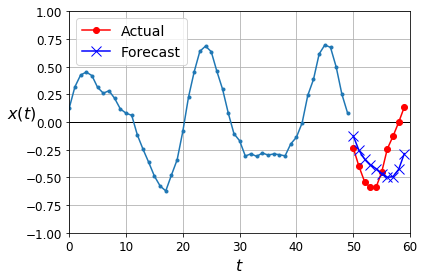

In [102]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0]) #1
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual") #2
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10) #3
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()    

Second option is to train an RNN to predict all 10 next values at once.

We first need to regenerate the sequences with 9 more time steps.

In [103]:
series = generate_time_series(10000, n_steps + 10) # 10 steps ahead
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [104]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.05))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 11ms/step - loss: 0.1140 - val_loss: 0.0857
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0687 - val_loss: 0.0654
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0692 - val_loss: 0.0888
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0610 - val_loss: 0.0512
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0916 - val_loss: 0.1654
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1126 - val_loss: 0.1238
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1209 - val_loss: 0.1311
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1130 - val_loss: 0.1269
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1123 - val_loss: 0.1331
Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.1096 - val_loss: 0

Now, predicting the next 10 values at once easily:

In [105]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

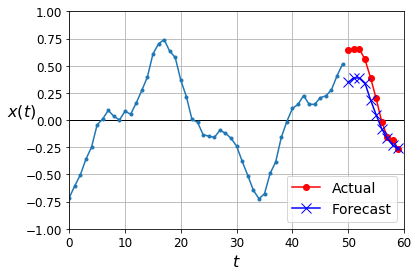

In [106]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Instead of training the model to forecast the next 10 values at the very last step,  we can train it to forecast the next 10 values at each and every time step.

Instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [109]:
np.random.seed(42)
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_head in range(10):
    Y[:,:, step_head - 1] = series[:,step_head:step_head + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test  = Y[9000:]

In [110]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [111]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# all outputs are needed for training, 
# but only the output at the last time step is useful for predictions and evaluation.
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))


Epoch 1/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0451 - last_time_step_mse: 0.0351 - val_loss: 0.0369 - val_last_time_step_mse: 0.0267
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0357 - last_time_step_mse: 0.0251 - val_loss: 0.0352 - val_last_time_step_mse: 0.0269
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0280 - last_time_step_mse: 0.0178 - val_loss: 0.0248 - val_last_time_step_mse: 0.0140
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0252 - last_time_step_mse: 0.0154 - val_loss: 0.0246 - val_last_time_step_mse: 0.0151
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0227 - last_time_step_mse: 0.0122 - val_loss: 0.0227 - val_last_time_step_mse: 0.0134
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0218 - last_time_step_mse: 0.0113 - val_loss: 0.0210 - val_last_time_step_mse: 0.0099
Epoch 7/20
219/219 [==

We get a validation MSE of 0.006.

In [112]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

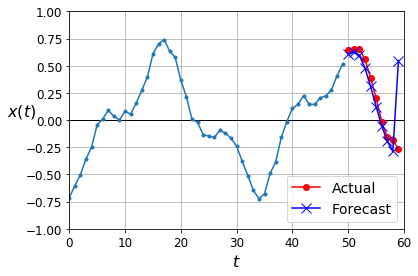

In [113]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

You can combine this approach with the first one: just predict the next 10 values then concatenate to the input series and use the model again and repeat the process. With this approach you can generate arbitrarily long sequences but it may not be accurate for long-term predictions.

### Deep RNN with Layer Normalization

In [114]:
from tensorflow.keras.layers import LayerNormalization

In [115]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [116]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1381 - last_time_step_mse: 0.1306 - val_loss: 0.0591 - val_last_time_step_mse: 0.0515
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0535 - last_time_step_mse: 0.0455 - val_loss: 0.0495 - val_last_time_step_mse: 0.0419
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0470 - last_time_step_mse: 0.0392 - val_loss: 0.0451 - val_last_time_step_mse: 0.0378
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0423 - last_time_step_mse: 0.0344 - val_loss: 0.0397 - val_last_time_step_mse: 0.0319
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0377 - last_time_step_mse: 0.0292 - val_loss: 0.0355 - val_last_time_step_mse: 0.0272
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0339 - last_time_step_mse: 0.0246 - val_loss: 0.0323 - val_last_time_step_mse: 0.0231
Epoch 7/20
219/219 [==

## LSTM cells